In [77]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score, cross_validate

# Some functions created for graphing & data manipulation
from clean_functions import convertAge, convertSalary, convertChildren, childrenOrNotInUniverse, bar_charts, dataPrep

# To use SQL functionality
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

## Reading In Data

In [2]:
# Setting header to none, as there are no column titles
train_data = pd.read_csv('./census_income_learn.csv', header=None)
train_data['source'] = 'train'

test_data = pd.read_csv('./census_income_test.csv', header=None)
test_data['source'] = 'test'

data = pd.concat([train_data, test_data])

In [3]:
duplicate_no = len(data) - len(data.drop_duplicates())
print('potential duplicates:', duplicate_no)

# with no unique ID its hard to tell if people are being counted twice. 
# Model gave higher test scores without dropping
# data = data.drop_duplicates()

potential duplicates: 4112


In [ ]:
# Confusion over number of variables and names, comparing unique values to last section of metadata
for i in range(42):
    print('Column', i)
    print(data[i].unique())
    print('')
# For readability purpose, not printing this

In [6]:
# Creating column names and assigning to train and test df
headers = ['Age', 'Class of Worker', 'detailed industry recode', 'detailed occupation recode',
          'education', 'wage per hour', 'enroll in edu inst last wk', 'marital stat',
          'major industry code', 'major occupation code', 'race', 'hispanic origin', 'sex',
          'member of a labor union', 'reason for unemployment', 'full or part time employment stat',
          'capital gains', 'capital losses', 'dividends from stocks', 'tax filer stat', 
          'region of previous residence', 'state of previous residence',
          'detailed household and family stat', 'detailed household summary in household',
          'instance weight', 'migration code-change in msa', 'migration code-move within reg',
          'migration code-change in reg', 'live in this house 1 year ago',
          'migration prev res in sunbelt', 'num persons worked for employer',
          'family members under 18', 'country of birth father', 'country of birth mother',
          'country of birth self', 'citizenship', 'own business or self employed',
          'fill inc questionnaire for veterans admin', 'veterans benefits', 'weeks worked in year',
          'year', 'salary', 'source']

print(len(headers))
data.columns = headers

43


## Exploratory Analysis

In [ ]:
# looking at value counts to get better idea of how missing data is handled
for i in headers:
    print(i)
    print(data[i].value_counts())
    print('')

In [8]:
# Converting All Children or Not in universe values to NaN and banding age groups
data_2 = data.copy()
data_2['education'] = data_2['education'].apply(lambda x: convertChildren(x))
data_2['Age'] = data_2['Age'].apply(lambda x: convertAge(x))
data_2['salary'] = data_2['salary'].apply(lambda x: convertSalary(x))
data_2 = data_2.applymap(lambda x: childrenOrNotInUniverse(x))
data_2 = data_2.dropna(subset = ["education"])
data_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176230 entries, 0 to 99760
Data columns (total 43 columns):
Age                                          176230 non-null object
Class of Worker                              128268 non-null object
detailed industry recode                     176230 non-null int64
detailed occupation recode                   176230 non-null int64
education                                    176230 non-null object
wage per hour                                176230 non-null int64
enroll in edu inst last wk                   9388 non-null object
marital stat                                 176230 non-null object
major industry code                          128090 non-null object
major occupation code                        128090 non-null object
race                                         176230 non-null object
hispanic origin                              176230 non-null object
sex                                          176230 non-null object
member of a

In [ ]:
# Variables which didn't have a significant portion missing, and made sense in predicting salary
categoric = ['Age', 'Class of Worker', 'education', 'marital stat', 'race', 'sex',
            'full or part time employment stat', 'num persons worked for employer',
            'country of birth self', 'citizenship', 'own business or self employed',
            'major industry code', 'major occupation code']

for i in categoric:
    print(i)
    bar_charts(i, data=data_2, hue="salary")
    print('')
    
# Thought it was weird that employment stat had a value "children or armed forces" 
# but i've excluded children so it should just be armed forces

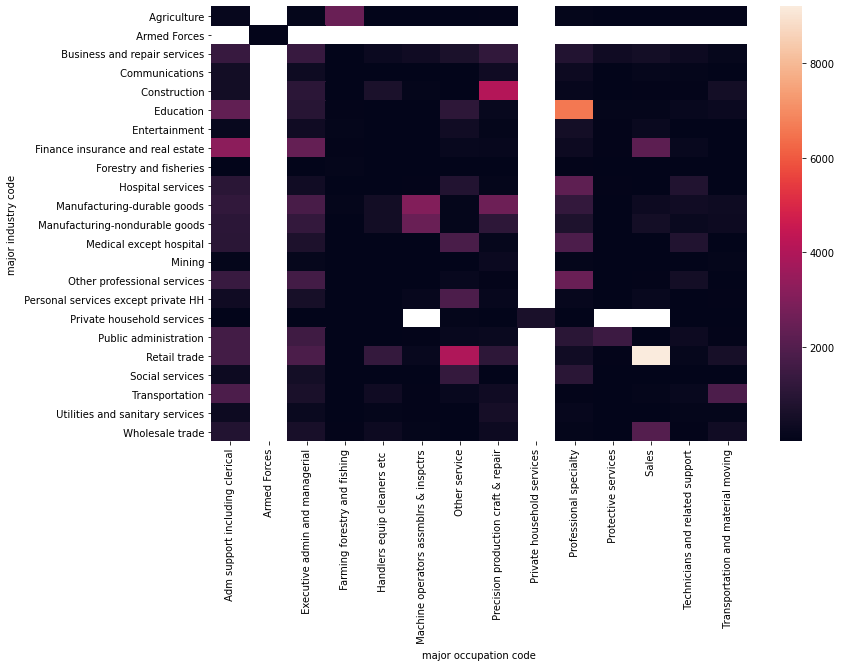

In [10]:
# Checking correlation between occupation and industry
q = """
SELECT 
"major industry code",
"major occupation code",
count(*) as count
FROM
data_2
GROUP BY 1,2
"""

test_corr = pysqldf(q).dropna()
test_corr = test_corr.pivot(index="major industry code", 
                            columns="major occupation code", 
                            values="count")

plt.figure(figsize=(12,8))
ax = sns.heatmap(test_corr)
plt.show()

# I'm not worried about measuring the same thing twice here, most of the occupations have a mixture of industries

## Data Modelling
#### Logistic Regression & Random Forest Approach

In [11]:
# Handling Class Imbalance - Upsampling needed for over $50,000 group
print('salary over $50,000:')
print(data_2.salary.value_counts())
print('')

salary over $50,000:
0    158101
1     18129
Name: salary, dtype: int64



In [12]:
model_variables = ['Age', 
                  'Class of Worker', 
                  'education', 
                  'marital stat', 
                  'race', 
                  'sex',
                  'full or part time employment stat', 
                  'num persons worked for employer',
                  'own business or self employed', 
                  'major industry code', 
                  'major occupation code', 
                  'salary', 
                  'source',
#                   'hispanic origin'
                  'tax filer stat'
                  ]
   

In [ ]:
def sixFoldCVScore(model, x, y):
    cv = RepeatedKFold(n_splits=3, n_repeats=2, random_state=1)
    scoring = ['accuracy', 'precision', 'recall', 'f1']
    scores = cross_validate(model, x, y, scoring=scoring, cv=cv, n_jobs=-1)
    print('accuracy:', round(np.average(scores['test_accuracy']),3))
    print('precision:', round(np.average(scores['test_precision']),3))
    print('recall:', round(np.average(scores['test_recall']),3))
    print('f1:', round(np.average(scores['test_f1']),3))

In [69]:
sixFoldCVScore(lr, test_x, test_y)

accuracy: 0.91
precision: 0.67
recall: 0.34
f1: 0.45


## Logistic Regression

In [73]:
print("Logistic Regression w/o upsample")
train_x, test_x, train_y, test_y, column_names = dataPrep(data_2, 
                                                          model_variables, 
                                                          upsample=False,
                                                          scale=False)

lr = LogisticRegression(max_iter=10000).fit(train_x, train_y)
sixFoldCVScore(lr, test_x, test_y)
print('')

print("Logistic Regression with upsample")
train_x, test_x, train_y, test_y, column_names = dataPrep(data_2, 
                                                          model_variables,
                                                          drop_first=True,
                                                          scale=True)

lr = LogisticRegression(max_iter=10000).fit(train_x, train_y)
sixFoldCVScore(lr, test_x, test_y)
print('')

Logistic Regression w/o upsample
accuracy: 0.91
precision: 0.67
recall: 0.34
f1: 0.45

Logistic Regression with upsample
accuracy: 0.81
precision: 0.8
recall: 0.83
f1: 0.81



In [74]:
coeffs = pd.DataFrame(list(zip(column_names, lr.coef_[0])), 
                      columns=['var','coeff'])

print('highest positive coefficients')
print(coeffs.sort_values(by='coeff',ascending=False).head(15))
print('')

print('lowest negative coefficients')
print(coeffs.sort_values(by='coeff',ascending=False).tail(15))
print('')

highest positive coefficients
                                                  var     coeff
6                                         Age_45 - 50  0.730616
7                                         Age_50 - 55  0.706053
5                                         Age_40 - 45  0.657102
69  major occupation code_ Executive admin and man...  0.655395
9                                         Age_60 - 70  0.648290
38                                          sex_ Male  0.632960
25  education_ Masters degree(MA MS MEng MEd MSW MBA)  0.622953
4                                         Age_35 - 40  0.619981
22              education_ Bachelors degree(BA AB BS)  0.603765
8                                         Age_55 - 60  0.593300
26  education_ Prof school degree (MD DDS DVM LLB JD)  0.570040
76      major occupation code_ Professional specialty  0.556891
10                                        Age_70 - 80  0.508927
23               education_ Doctorate degree(PhD EdD)  0.487555
3         

## Random Forest

In [85]:
train_x, test_x, train_y, test_y, column_names = dataPrep(data_2, model_variables, drop_first=False)

param_grid={'max_depth': [17, 19, 21], 
            'max_features': [0.4, 0.5, 0.6],
            'min_samples_leaf': [4, 5, 6]
           }

clf = GridSearchCV(rf, 
                   param_grid=param_grid, 
                   scoring='f1',
                   n_jobs=-1,
                   cv=5)

search = clf.fit(train_x, train_y)
search.best_params_

{'max_depth': 17, 'max_features': 0.4, 'min_samples_leaf': 6}

In [87]:
# # test1 = search.best_params_
# test2 = 

In [86]:
print("Random Forest with base classes")
train_x, test_x, train_y, test_y, column_names = dataPrep(data_2, model_variables, drop_first=True)

rf = RandomForestClassifier(max_depth=12, 
                            max_features=0.2, 
                            min_samples_leaf=15).fit(train_x, train_y)
sixFoldCVScore(rf, test_x, test_y)
print('')

print("Random Forest with no base classes")
train_x, test_x, train_y, test_y, column_names = dataPrep(data_2, model_variables)

rf = RandomForestClassifier(max_depth=17, 
                            max_features=0.4, 
                            min_samples_leaf=6).fit(train_x, train_y)
sixFoldCVScore(rf, test_x, test_y)
print('')

Random Forest with base classes
accuracy: 0.82
precision: 0.8
recall: 0.84
f1: 0.82

Random Forest with no base classes
accuracy: 0.87
precision: 0.85
recall: 0.9
f1: 0.87



## Bayesian Model

In [62]:
print("Naive Bayes with no base classes")
train_x, test_x, train_y, test_y, column_names = dataPrep(data_2, 
                                                          model_variables,
                                                          upsample=True)

gnb = GaussianNB()
gnb.fit(train_x, train_y)
pred_y = gnb.predict(test_x)
sixFoldCVScore(gnb, test_x, test_y)
print('')

Naive Bayes with no base classes
accuracy: 0.6593159467420002
precision: 0.5996085977748086
recall: 0.9551259562824597
f1: 0.7367157726112845

